In [ ]:
!pip install qiskit==0.43.2 qiskit-machine-learning==0.6.0 qiskit-algorithms==0.2.0 qiskit-aer pylatexenc

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay
from qiskit.utils import algorithm_globals
from qiskit_aer import Aer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit.visualization import circuit_drawer
from sklearn.base import BaseEstimator

In [ ]:
# Set random seed for reproducibility
algorithm_globals.random_seed = 12345

In [ ]:
def load_data():
    url = "https://raw.githubusercontent.com/SahandNamvar/Binary-classification-Alzheimer-disease/refs/heads/main/alzheimers_disease_data.csv"
    df = pd.read_csv(url)

    # Drop ID or irrelevant text columns
    df = df.drop(columns=["PatientID", "DoctorInCharge"], errors='ignore')

    # Ensure 'Diagnosis' is the label
    y = df["Diagnosis"]

    # Keep only numeric columns for features, excluding 'Diagnosis'
    X = df.drop(columns=["Diagnosis"])
    X = X.select_dtypes(include=[np.number])

    # Remove rows with NaN in features or labels
    mask = X.notnull().all(axis=1) & y.notnull()
    X = X[mask]
    y = y[mask]

    print(f"✅ Loaded dataset with {len(X)} samples and {X.shape[1]} features.")
    return X, y.astype(int)

In [ ]:
# Classical kNN
def train_knn(X_train, y_train):
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)
    return knn

In [ ]:
# Quantum-inspired kNN class
class QkNN:
    def __init__(self, n_neighbors=3, feature_dim=None):
        self.n_neighbors = n_neighbors
        self.feature_dim = feature_dim

    def normalize(self, X):
        # Normalize each sample vector to unit length (like a quantum state)
        norms = np.linalg.norm(X, axis=1, keepdims=True)
        return X / norms

    def fit(self, X, y):
        self.X_train = self.normalize(X)
        self.y_train = np.array(y.reset_index(drop=True))  # FIX: Reset index

    def predict(self, X_test):
        X_test_norm = self.normalize(X_test)
        y_pred = []
        for test_vec in X_test_norm:
            sims = np.dot(self.X_train, test_vec)  # Cosine similarity
            top_k_idx = np.argsort(sims)[-self.n_neighbors:][::-1]
            top_k_labels = self.y_train[top_k_idx]
            predicted = np.bincount(top_k_labels).argmax()
            y_pred.append(predicted)
        return np.array(y_pred)

In [ ]:
# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Healthy', 'Alzeihmer\'s'])
    plt.yticks(tick_marks, ['Healthy', 'Alzeihmer\'s'])

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [ ]:
# Plot ROC Curve
def plot_roc(y_true, y_scores, title):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(4, 3))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

In [ ]:
# Optional: Visualize feature vector like a quantum state
def visualize_feature_vector(feature_vector):
    plt.figure(figsize=(8, 2))
    plt.bar(range(len(feature_vector)), feature_vector)
    plt.title("Sample Feature Vector Visualization")
    plt.xlabel("Feature Index")
    plt.ylabel("Value")
    plt.tight_layout()
    plt.show()

In [ ]:
# Main comparison pipeline
def compare_knn_qknn():
    print("🔄 Loading and preprocessing data...")
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    feature_dim = X_train.shape[1]

    print("\n🧠 Training Classical kNN...")
    knn_model = train_knn(X_train, y_train)

    print("\n⚛️ Training Quantum-inspired kNN (QkNN)...")
    qknn_model = QkNN(n_neighbors=3, feature_dim=feature_dim)
    qknn_model.fit(X_train, y_train.reset_index(drop=True))  # Important fix

    print("\n📊 Evaluating Models:")
    knn_pred = knn_model.predict(X_test)
    knn_accuracy = accuracy_score(y_test, knn_pred)
    print(f"Classical kNN Accuracy: {knn_accuracy * 100:.2f}%")

    qknn_pred = qknn_model.predict(X_test)
    qknn_accuracy = accuracy_score(y_test, qknn_pred)
    print(f"Quantum-inspired kNN Accuracy: {qknn_accuracy * 100:.2f}%")

    # Confusion Matrices
    print("\nConfusion Matrix - Classical kNN:")
    plot_confusion_matrix(y_test, knn_pred, "Classical kNN")

    print("Confusion Matrix - Quantum-inspired kNN:")
    plot_confusion_matrix(y_test, qknn_pred, "Quantum-inspired kNN")

    # ROC Curves
    print("\nROC Curve - Classical kNN:")
    if hasattr(knn_model, "predict_proba"):
        knn_probs = knn_model.predict_proba(X_test)[:, 1]
        plot_roc(y_test, knn_probs, "Classical kNN")

    print("ROC Curve - Quantum-inspired kNN:")
    plot_roc(y_test, qknn_pred, "Quantum-inspired kNN (Approx)")

    # Visualize feature map
    print("\n🌀 Visualizing Feature Vector (Quantum Input Example):")
    visualize_feature_vector(X_train[0])

🔄 Loading and preprocessing data...
✅ Loaded dataset with 2149 samples and 32 features.

🧠 Training Classical kNN...

⚛️ Training Quantum-inspired kNN (QkNN)...

📊 Evaluating Models:
Classical kNN Accuracy: 67.91%
Quantum-inspired kNN Accuracy: 67.13%

Confusion Matrix - Classical kNN:


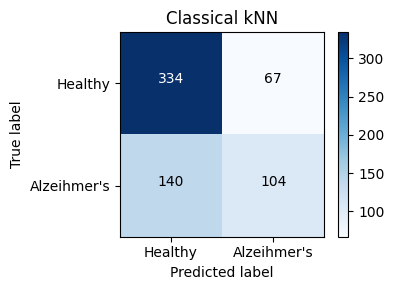

Confusion Matrix - Quantum-inspired kNN:


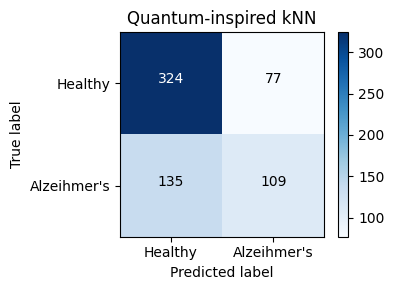


ROC Curve - Classical kNN:


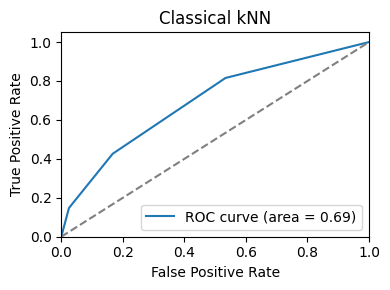

ROC Curve - Quantum-inspired kNN:


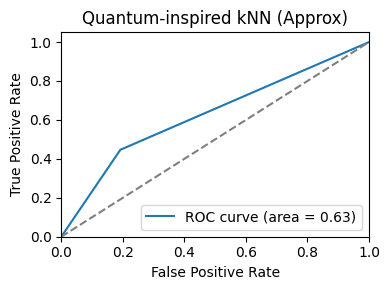


🌀 Visualizing Feature Vector (Quantum Input Example):


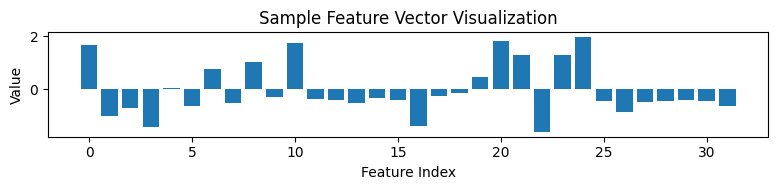

In [ ]:
# Run the pipeline
compare_knn_qknn()